# Resonatpr Flux sweep

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from HelpModule import *
# from E5080B_driver import *
# from SGS100A_driver import *
# from spirack import SPI_rack, S4g_module
# from IPython.display import clear_output
# from time import sleep
# from Keythley_2450 import Keithley2450

# from qcodes.dataset import (
#     Measurement,
#     initialise_database,
#     new_experiment,
#     plot_dataset,
# )
# from qcodes.instrument_drivers.Keithley import Keithley2450


In [2]:
# vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
# #twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
# smu = Keithley2450('QRF_SMU','TCPIP0::192.168.0.4::inst0::INSTR')
# vna.open()
# #twpa.open()
# smu.reset()


[QRF_SMU(Keithley2450)] Could not connect at TCPIP0::192.168.0.4::inst0::INSTR
Traceback (most recent call last):
  File "c:\Users\tii_s\miniconda3\envs\tii_sd_control_env\Lib\site-packages\qcodes\instrument\visa.py", line 148, in _connect_and_handle_error
    visa_handle, visabackend, resource_manager = self._open_resource(
                                                 ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tii_s\miniconda3\envs\tii_sd_control_env\Lib\site-packages\qcodes\instrument\visa.py", line 177, in _open_resource
    resource = resource_manager.open_resource(address)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tii_s\miniconda3\envs\tii_sd_control_env\Lib\site-packages\pyvisa\highlevel.py", line 3284, in open_resource
    res.open(access_mode, open_timeout)
  File "c:\Users\tii_s\miniconda3\envs\tii_sd_control_env\Lib\site-packages\pyvisa\resources\resource.py", line 282, in open
    self.session, status = self._resource_manager.open_bare_resource(


VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [9]:
from pyvisa import VisaIOError
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from IPython.display import clear_output
from time import sleep
from Keythley_2450 import Keithley2450 

from qcodes.dataset import (
    Measurement,
    initialise_database,
    new_experiment,
    plot_dataset,
)
from qcodes.instrument_drivers.Keithley import Keithley2450

lo = SGS100A_driver('TCPIP0::192.168.0.36::inst0::INSTR')
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
smu = Keithley2450('QRF_SMU','TCPIP0::192.168.0.4::inst0::INSTR')

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04632152, firmware:1.7.12b) in 0.02s


In [10]:

vna.open()
#twpa.open()
smu.reset()


In [3]:
with (run(vna)):
    mag, phase =  vna.get_data() 

In [8]:

#twpa.open()
smu.close()


In [56]:
from datetime import datetime
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'RK_TWPA_coil-current-sweep'
params['qubit_name'] = 'LO-on_6.15GHz_-2.5dBm_-50dBm'
params['qubit_power'] = -20
params['vna_power'] = -50
params['f_span'] = 4000
params['center_freq'] =  7.5e9 #Hz
#params['twpa_power'] = -2.73
#params['twpa_frequency'] = 7098.0
params['span_freq'] = 4000
params['flux_curr'] = 0
params['temp'] = 23
params['comment'] = "Flux Att: 10dB @ 4 K + 3dB @ 10 K \n" +\
                    "# Drive Att: 52dB Total (30dB @ 20 mK)" +\
                    "# TWPA biased " +\
                    "# Connection Diagram: TII 2q 06-10-23" +\
                    "# Clean current source\n"

data_format = 'MA'
npoints = 5001

In [23]:
# Get low power pectrum
#twpa.start_rf()
freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = 20, power = -60, sleep_t = 5, npoints = 1000, data_format = 'MA')
#twpa.stop_rf()

#Caculate the quality factor
f_c, Qf,_ = Q(freqs,mag, True)

print('Center frequency: %2.2f Hz'%f_c)
print('Quality Factor: %2.3f'%Qf)
params['center_freq'] = f_c
#plt.plot(freqs*1e-9,mag)

Center frequency: 7330800150.15 Hz
Quality Factor: 1939.231


## Run a flux sweep with manual current control

In [59]:
# Setup the sweep parameters

initial_current = 4.8e-3
final_current = 5.3e-3
step_current = 0.025e-3
# params['center_freq'] =  7332490000.57
# params['span_freq'] = 5000
vna.set_sweep_npoints(npoints)
current_array = np.arange(initial_current,final_current,step_current)

#Intiialize SMU
smu.terminals("front")
smu.source.function("current")
smu.source.current(1E-6)  # Put 1uA through the resistor

delays = np.ndarray(len(current_array))
mags = np.ndarray((len(current_array),npoints))
phases = np.ndarray((len(current_array),npoints))
Z = np.ndarray((len(current_array),npoints),dtype=complex)

mags[:] = 0
phases[:] = 0
Z[:] = 0

vna.set_center_frequency(params['center_freq'])
vna.set_span_frequency(params['span_freq'])
vna.set_data_format('MA')
sleep(0.5)

freqs, mag, phase = meas_spectrum(vna, 
                                  f_c=params['center_freq']+0.1e6, 
                                  f_span = params['span_freq'], 
                                  power = params['vna_power'], 
                                  npoints=npoints,
                                  sleep_t = 0.3,
                                  avg_count = 100)

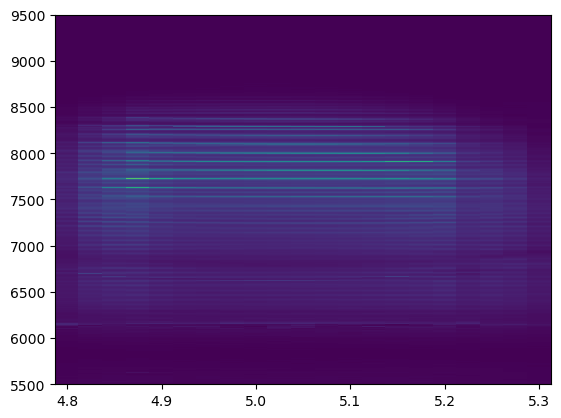

In [60]:
# run sweep

# params['center_freq'] =  7332490000.57
# params['span_freq'] = 5000
vna.set_sweep_npoints(npoints)
current_array = np.arange(initial_current,final_current,step_current)
vna.start_rf()
#twpa.start_rf()
sleep(1)

delay = 5
voltage = smu.sense.function("voltage")

try:
    for idx,curr in enumerate(current_array):   
        clear_output(wait=True)
    
        #Update Flux Current
        smu.source.current(curr)
        
        with (smu.output_enabled.set_to(True), run(vna)):
            voltage = smu.sense.voltage()
            sleep(delay)
            mag, phase =  vna.get_data()      
            
        mags[idx] = mag
        phases[idx] = phase    
    
        plt.pcolor(current_array*1e3,freqs*1e-6,mags.T)
        plt.show()
except:
    raise
    #print("Stopped")
finally:
    #twpa.stop_rf()
    vna.stop_rf()
    smu.output_enabled.set_to(False)

Z = toComplex(mags,phases)

In [61]:
import plotly.graph_objects  as go
fig_current=go.Figure(data=go.Heatmap(z=mags.T, x=current_array*1e3, y=freqs*1e-6, colorscale='Viridis')) #, zsmooth='best')) #zmax=20,  zmin=0, 
fig_current.update_layout(
    autosize=False,
    width=800,
    height=500)
fig_current.update_yaxes(automargin=True)
fig_current.update_xaxes(automargin=True)
fig_current.show()

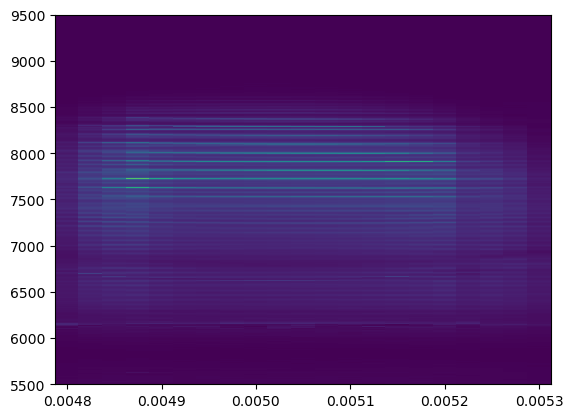

file saved as RK_TWPA_coil-current-sweep_LO-on_6.15GHz_-2.5dBm_-50dBm_20240902_2001


In [62]:
plt.pcolor(current_array,freqs*1e-6,mags.T)
plt.show()

header_str = get_plot_str(params)
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
np.savez("./data/"+filename,
         header = header_str,
         freqs = freqs,
         curr=current_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

In [34]:
#twpa.stop_rf()
vna.stop_rf()
smu.output_enabled.set_to(False)
lo.close

AttributeError: 'E5080B_driver' object has no attribute '_inst'